Question 01: [25 marks]: A Basic Neural Network - Digit Recognition

A. Download the MNIST dataset using torch-vision. Split into train, test and validationdataset. Apply Augmentions to images:

a. Training dataset: RandomRotation(5 degrees), RandomCrop(size=28, padding =2), ToTensor and Normalize.

b. Testing dataset and validation dataset: ToTensor and Normalize

In [7]:
import torch
print(torch.__version__)

2.0.0+cu118


In [8]:
import torch
from torchvision import datasets, transforms


train_data = datasets.MNIST(root='./data', train=True, download=True)
test_data = datasets.MNIST(root='./data', train=False, download=True)

#splitting the dataset into training testing and validation
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

#defining transformation
train_transform = transforms.Compose([transforms.RandomRotation(5),transforms.RandomCrop(28, padding=2),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
val_test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

#applying transformations
train_data.dataset.transform = train_transform
val_data.dataset.transform = val_test_transform
test_data.transform = val_test_transform

# Creating data loaders for each dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 93889148.89it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15508346.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25959676.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9141328.58it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



B. Plot a Few Images from each class. Create a data loader for the training dataset as well as the testing dataset.

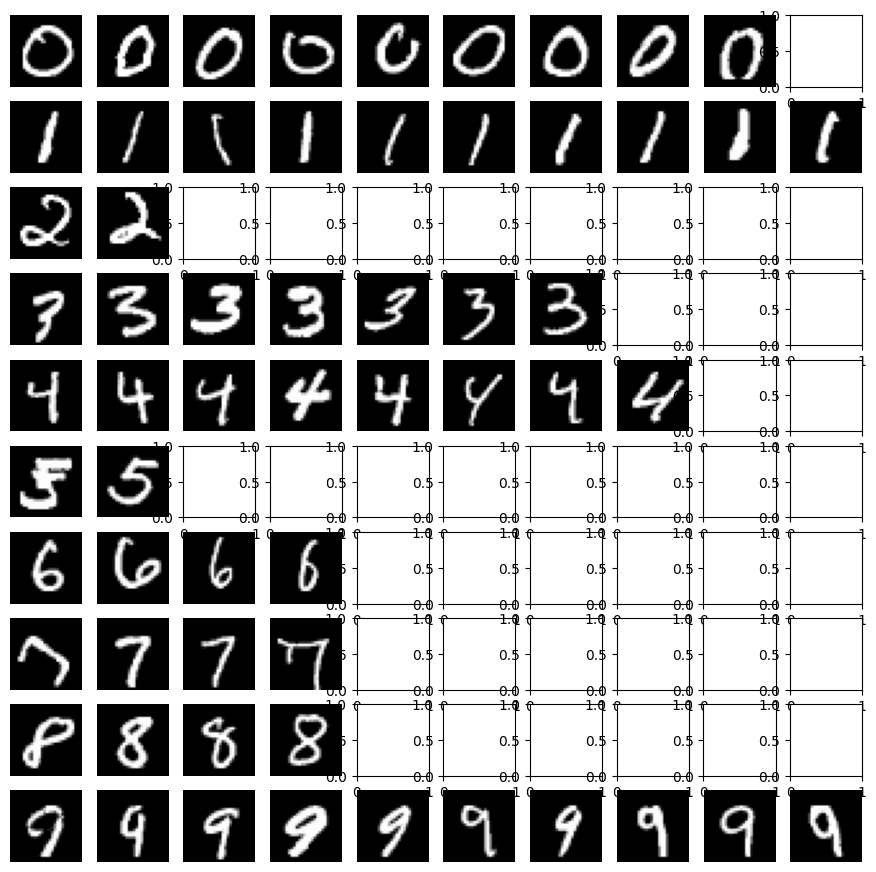

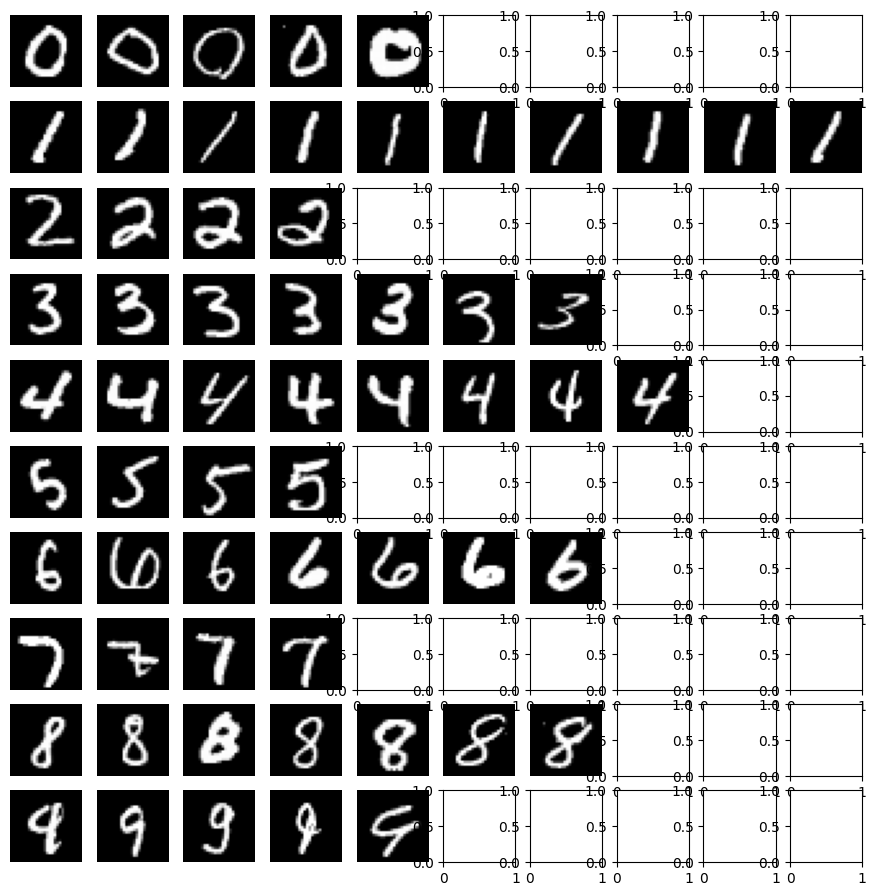

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# extracting a batch of images and labels from the training set
images, labels = next(iter(train_loader))

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(11, 11))
for i in range(10):
    idx = np.where(labels == i)[0]
    num_images = min(len(idx), 10)
    for j in range(num_images):
        axs[i,j].imshow(images[idx[j]][0], cmap='gray')
        axs[i,j].axis('off')
plt.show()

# extracting a batch of images and labels from the test set
images, labels = next(iter(test_loader))

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(11, 11))
for i in range(10):
    idx = np.where(labels == i)[0]
    num_images = min(len(idx), 10)
    for j in range(num_images):
        axs[i,j].imshow(images[idx[j]][0], cmap='gray')
        axs[i,j].axis('off')
plt.show()


C. Write a 3-Layer MLP using PyTorch all using Linear layers. Print the number of trainable parameters of the model.

In [10]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#defining the model architecture
input_dim = 784 # 28x28 images flattened into a vector
hidden_dim = 256
output_dim = 10 # 10 classes

model = MLP(input_dim, hidden_dim, output_dim)

number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {number_parameters}')


Number of trainable parameters: 269322


D. Train the model for 5 epochs using Adam as the optimizer and CrossEntropyLoss as the Loss Function. Make sure to evaluate the model on the validation set after each epoch and save the best model as well as log the accuracy and loss of the model on training and validation data at the end of each epoch.

In [11]:
import torch.optim as optim
import torch.nn.functional as F


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5
train_losses, train_accs = [], []
valid_losses, valid_accs = [], []

# Initializing the best validation accuracy and the corresponding model weights as intially 0
best_valid_acc = 0.0
best_model_weights = None


for epoch in range(num_epochs):
   
    train_loss, train_acc = 0.0, 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images.view(-1, input_dim))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_acc = 100.0 * train_acc / len(train_data)
    train_accs.append(train_acc)
    
    valid_loss, valid_acc = 0.0, 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.view(-1, input_dim))
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            valid_acc += torch.sum(preds == labels.data)

    valid_loss /= len(val_loader)
    valid_losses.append(valid_loss)

    valid_acc = 100.0 * valid_acc / len(test_data)
    valid_accs.append(valid_acc)
    
    # Printing the training and validation losses and accuracies for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')
    
    # Saving the best model weights based on validation accuracy
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model_weights = model.state_dict()

# Load the best model weights
model.load_state_dict(best_model_weights)

print()

print(f'Train Losses: {train_losses}')
print(f'Train Accuracies: {train_accs}')
print(f'Validation Losses: {valid_losses}')
print(f'Validation Accuracies: {valid_accs}')


Epoch [1/5], Train Loss: 0.3426, Train Acc: 89.53%, Valid Loss: 0.1749, Valid Acc: 94.80%
Epoch [2/5], Train Loss: 0.1567, Train Acc: 95.15%, Valid Loss: 0.1606, Valid Acc: 95.21%
Epoch [3/5], Train Loss: 0.1142, Train Acc: 96.39%, Valid Loss: 0.1171, Valid Acc: 96.22%
Epoch [4/5], Train Loss: 0.0931, Train Acc: 97.05%, Valid Loss: 0.1145, Valid Acc: 96.58%
Epoch [5/5], Train Loss: 0.0777, Train Acc: 97.56%, Valid Loss: 0.1072, Valid Acc: 96.75%

Train Losses: [0.34263722422292164, 0.15669779711976992, 0.11424322285548881, 0.09314603183913947, 0.0776824917262563]
Train Accuracies: [tensor(89.5280), tensor(95.1460), tensor(96.3920), tensor(97.0520), tensor(97.5560)]
Validation Losses: [0.17490152314684954, 0.16058851376911448, 0.117056212411707, 0.11453412894076508, 0.10720585114589543]
Validation Accuracies: [tensor(94.8000), tensor(95.2100), tensor(96.2200), tensor(96.5800), tensor(96.7500)]


E. Visualize correct and Incorrect predictions along with Loss-Epoch and Accuracy-Epoch graphs for both training and validation.

Epoch [1/5], Train Loss: 0.0701, Train Acc: 97.71%, Valid Loss: 0.0948, Valid Acc: 97.07%
Epoch [2/5], Train Loss: 0.0587, Train Acc: 98.05%, Valid Loss: 0.0999, Valid Acc: 97.21%
Epoch [3/5], Train Loss: 0.0519, Train Acc: 98.28%, Valid Loss: 0.1172, Valid Acc: 96.41%
Epoch [4/5], Train Loss: 0.0459, Train Acc: 98.46%, Valid Loss: 0.0996, Valid Acc: 97.31%
Epoch [5/5], Train Loss: 0.0430, Train Acc: 98.53%, Valid Loss: 0.1213, Valid Acc: 96.58%
Train Losses: [0.34263722422292164, 0.15669779711976992, 0.11424322285548881, 0.09314603183913947, 0.0776824917262563, 0.07005824836339002, 0.05873209965395053, 0.0519101859321651, 0.045852800164890316, 0.043036648518834]
Train Accuracies: [tensor(89.5280), tensor(95.1460), tensor(96.3920), tensor(97.0520), tensor(97.5560), tensor(97.7060), tensor(98.0520), tensor(98.2840), tensor(98.4600), tensor(98.5340)]
Validation Losses: [0.17490152314684954, 0.16058851376911448, 0.117056212411707, 0.11453412894076508, 0.10720585114589543, 0.09480891531855

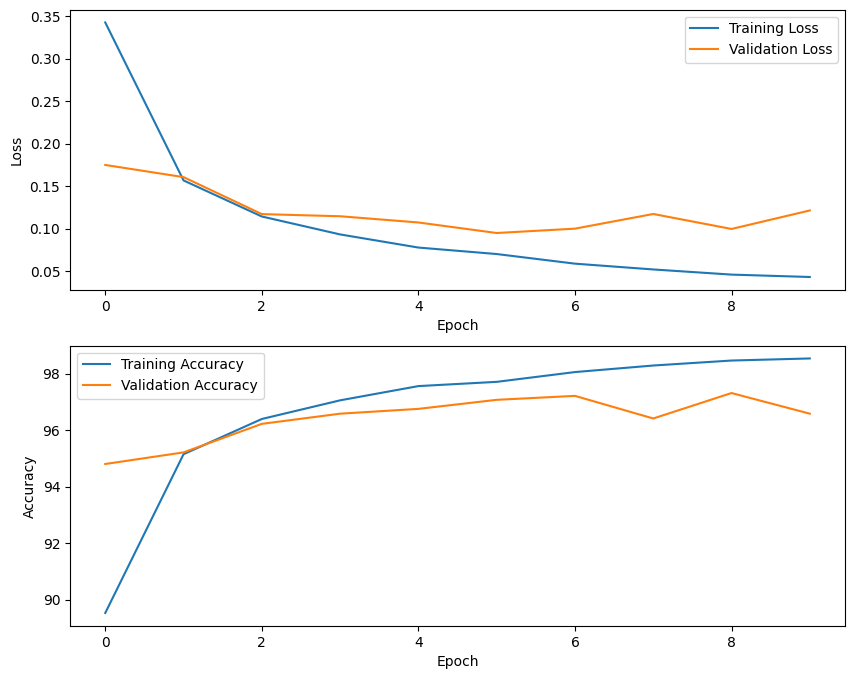

In [ ]:
import matplotlib.pyplot as plt

# Define empty lists to store correct and incorrect predictions for each epoch
train_correct_preds, train_incorrect_preds = [], []
valid_correct_preds, valid_incorrect_preds = [], []

# Train the model for the specified number of epochs
for epoch in range(num_epochs):
    # Train the model on the training set
    train_loss, train_acc = 0.0, 0.0
    epoch_train_correct_preds, epoch_train_incorrect_preds = [], []
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images.view(-1, input_dim))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)
        # Collect the correct and incorrect predictions for this batch
        for j in range(len(labels)):
            if preds[j] == labels[j]:
                epoch_train_correct_preds.append(images[j])
            else:
                epoch_train_incorrect_preds.append(images[j])
    train_loss /= len(train_loader)
    train_acc = 100.0 * train_acc / len(train_data)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # Save the correct and incorrect predictions for this epoch
    train_correct_preds.append(epoch_train_correct_preds)
    train_incorrect_preds.append(epoch_train_incorrect_preds)

    # Evaluate the model on the validation set
    valid_loss, valid_acc = 0.0, 0.0
    epoch_valid_correct_preds, epoch_valid_incorrect_preds = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.view(-1, input_dim))
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            valid_acc += torch.sum(preds == labels.data)
            # Collect the correct and incorrect predictions for this batch
            for j in range(len(labels)):
                if preds[j] == labels[j]:
                    epoch_valid_correct_preds.append(images[j])
                else:
                    epoch_valid_incorrect_preds.append(images[j])
    valid_loss /= len(val_loader)
    valid_acc = 100.0 * valid_acc / len(test_data)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    # Save the correct and incorrect predictions for this epoch
    valid_correct_preds.append(epoch_valid_correct_preds)
    valid_incorrect_preds.append(epoch_valid_incorrect_preds)

    # Print the training and validation losses and accuracies for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')
    
    # Save the best model weights based on validation accuracy
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model_weights = model.state_dict()

# Load the best model weights
model.load_state_dict(best_model_weights)

# Print the training and validation losses and accuracies for all epochs
print(f'Train Losses: {train_losses}')
print(f'Train Accuracies: {train_accs}')
print(f'Validation Losses: {valid_losses}')


def plot_predictions(epoch, correct_preds, incorrect_preds):
  # Plot the correct predictions
  fig, axs = plt.subplots(1, len(correct_preds), figsize=(20, 4))
  for i, image in enumerate(correct_preds):
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(f'Epoch {epoch+1}, Correct Prediction')
    axs[i].axis('off')
  plt.show()

  # Plot the incorrect predictions
  fig, axs = plt.subplots(1, len(incorrect_preds), figsize=(20, 4))
  for i, image in enumerate(incorrect_preds):
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(f'Epoch {epoch+1}, Incorrect Prediction')
    axs[i].axis('off')
  plt.show()


fig, axs = plt.subplots(2, figsize=(10, 8))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(train_accs, label='Training Accuracy')
axs[1].plot(valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

plot_predictions(num_epochs-1, train_correct_preds[-1], train_incorrect_preds[-1])
plot_predictions(num_epochs-1, valid_correct_preds[-1], valid_incorrect_preds[-1])


QUESTION 02:-

Question 02: [60 Marks]: ANN from Scratch!!

In this exercise, you need to predict the life of Abalone - a kind of shellfish, based on a number of characteristics (sex, length, diameter, height, weights in different forms, etc.). Model it as a classification problem to predict the class (based on the number of rings). The dataset is
available here.

A. For this classification, you need to use a multi-layer perceptron.

a. Preprocess & visualize the data. Create train, val, and test splits but take into consideration the class distribution (Hint: Look up stratified splits). ~ [5]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score


link = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
columns=["sex","length","diameter","height","whole_weight","shucked_weight","viscera_weight","shell_weight","rings"]
df = pd.read_csv(link, names=columns)
df.dropna(inplace=True)
df


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [2]:
df['sex'] = pd.Categorical(df['sex'])
df['sex'] = df['sex'].cat.codes
df


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


<ipython-input-3-5353b8105a31>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, ax = axs[index])
<ipython-input-3-5353b8105a31>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, ax = axs[index])
<ipython-input-3-5353b8105a31>:8: UserWarning: 

`distplot` is a deprecated function and will be

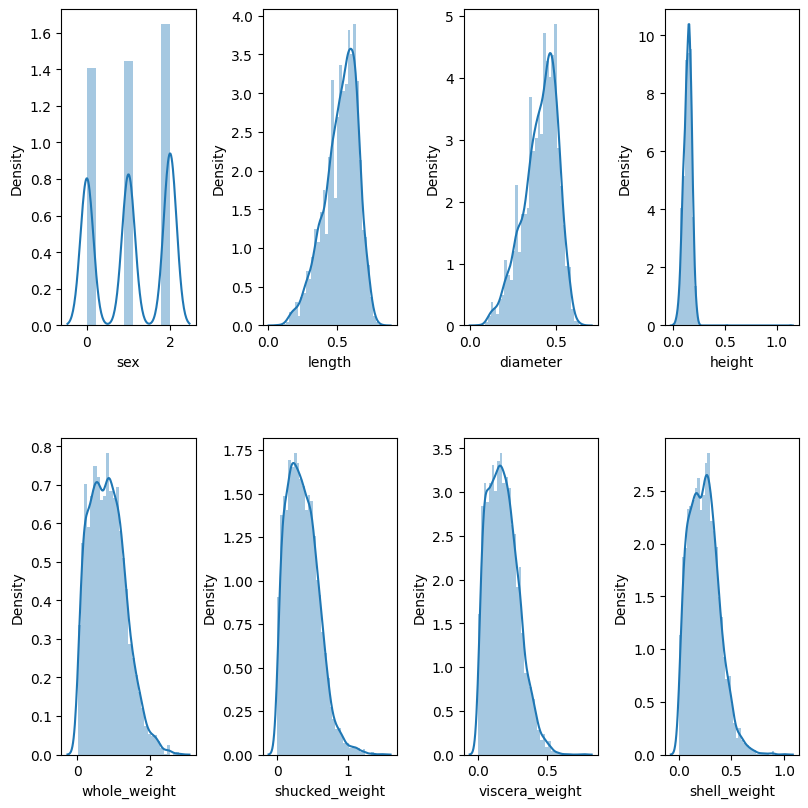

In [3]:
import seaborn as sns
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (8, 8))
index = 0

axs = axs.flatten()
df2 = df.drop(columns=['rings'])
for k, v in df2.items():
    sns.distplot(v, ax = axs[index])
    index += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

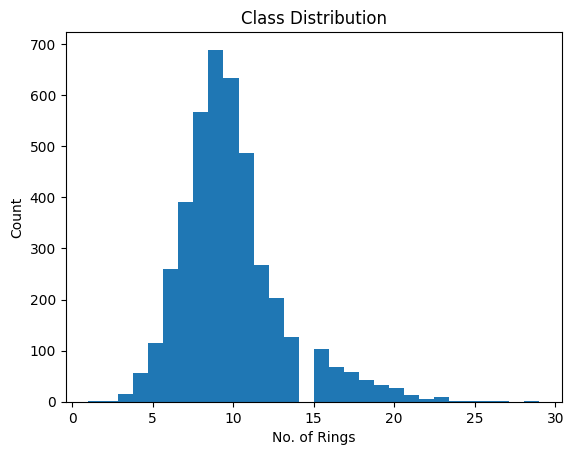

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to co


The Average Accuracy is: 0.2734040000220038
The Average Precision is: 0.2502405010513607
The Average Recall is: 0.2734040000220038


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
from sklearn.model_selection import StratifiedKFold

X = df.iloc[:, :-1]
y = df.iloc[:, -1]


plt.hist(y, bins=30)
plt.xlabel("No. of Rings")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

kf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam',max_iter=500, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []

for index_train, index_validation in kf.split(X, y):
    X_train, X_val = X.iloc[index_train], X.iloc[index_validation]
    y_train, y_val = y.iloc[index_train], y.iloc[index_validation]
    
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    
    accuracy_list.append(accuracy_score(y_val, y_val_pred))
    precision_list.append(precision_score(y_val, y_val_pred, average='weighted'))
    recall_list.append(recall_score(y_val, y_val_pred, average='weighted'))
    

accuracy = np.mean(accuracy_list)
precision = np.mean(precision_list)
recall = np.mean(recall_list)

print()
print("The Average Accuracy is:", accuracy)
print("The Average Precision is:", precision)
print("The Average Recall is:", recall)



B. b. Implement a multi-layer perceptron from scratch. This would include the following

a. Write activation functions.

b. Forward propagate the input.

c. Back propagate the error.

d. Train the network using stochastic gradient descent.

e. Predict the output for a given test sample and compute the accuracy.

activation functions

In [5]:
def softMax(X):
  e=np.exp(X)
  p=e/np.sum(e,axis=0)
  return p

def ReLU(z):
  return np.maximum(0,z)

def sigmoid(z):
  return 1./(1.+ np.exp(-z))

def tanh(x):
    t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return t

#learning parameter
lr=0.1


In [6]:
def dReLU(z):
    return (z > 0) * 1

def dSigmoid(z):
    return sigmoid(z) *(1-sigmoid (z))

def dTanh(z):
    return 1/(np.cosh(z)**2)

In [7]:
def forward_pass(x,w1,w2,activation_func="sigmoid"):
  if(activation_func=="sigmoid"):
    z1=np.matmul(x,w1)
    a1=sigmoid(z1)

    z2=a1.dot(w2)
    a2=sigmoid(z1)

    return a2

  elif(activation_func=="ReLU"):
    z1 = np.matmul(x,w1)
    a1 = ReLU(z1)
    
    z2 = a1.dot(w2)
    a2 = softMax(z2)

    return a2

  elif(activation_func=="Tanh"):
    z1 = np.matmul(x,w1)
    a1 = tanh(z1)
    
    z2 = a1.dot(w2)
    a2 = softMax(z2)

    return a2
    


In [8]:
def cross_entropy_loss(probab):
  return (-np.log2(probab))

In [9]:
def backward_pass(x,y,w1,w2,lr,pred,neurons_1,activation_func):
  if(activation_func=="sigmoid"):
    z1 = np.matmul(x,w1)
    a1=sigmoid(z1)
    
    z2 = a1.dot(w2)
    a2=sigmoid(z2)

    d2=np.array([pred[i]-1 if i==y else pred[i] for i in range((7)) ]).reshape(1,7)
    d1=np.multiply(w2.dot(d2.transpose()).transpose(),np.multiply(a1,1-a1))
    d1=d1.flatten().reshape (1, neurons_1)

  elif(activation_func=="ReLU"):
    z1 = np.matmul(x,w1)
    a1 = ReLU(z1)
    
    z2 = a1.dot(w2)
    a2 = softMax(z2)

    d2=np.array ([pred[i]-1 if i==y else pred[i] for i in range((7)) ]).reshape(1,7)
    derivative_a1=dReLU(a1)
    d1=np.multiply(w2.dot(d2.transpose()).transpose(),derivative_a1)
    d1=d1.flatten().reshape(1, neurons_1)

  elif(activation_func=="Tanh"):
    z1 = np.matmul(x,w1)
    a1 = tanh(z1)
    
    z2 = a1.dot(w2)
    a2 = softMax(z2)

    d2=np.array ([pred[i]-1 if i==y else pred[i] for i in range((7)) ]).reshape(1,7)
    derivative_a1=dTanh(a1)
    d1=np.multiply(w2.dot(d2.transpose()).transpose(),derivative_a1)
    d1=d1.flatten().reshape(1, neurons_1)


 #gradient
  w1_adj=x.transpose().dot(d1)
  w2_adj=a1.transpose().dot (d2)
  
  #update weights
  w1=w1-(lr*w1_adj)
  w2=w2-(lr*w2_adj)
  
  return (w1, w2)



In [10]:
def initialize_weights(x1, y1, numberOfNeurons,mode="uniform"):
  if mode=="uniform":
    l = []
    for i in range(x1*y1) :
      l.append(np.random.uniform(-6/ (numberOfNeurons**0.5),6/numberOfNeurons**0.5))
    return np.array(l).reshape(x1,y1)
  elif mode=="random":
    l=[]
    for i in range(x1*y1) :
      l.append(np.random.rand())
    return np.array(l).reshape(x1,y1)
  elif mode=="zero":
    return np.zeros((x1,y1))
  elif mode=="constant":
    l=[]
    for i in range(x1*y1) :
      l.append(1)
    return np.array(l).reshape(x1,y1)

In [11]:
from tqdm import tqdm
def train(x,y,learning_rate=0.1, epoch=10, neurons_1=128,activation_func="sigmoid",mode="uniform"):
  
  
  w1=np.array (initialize_weights(8, neurons_1, neurons_1,mode))
  w2=np.array (initialize_weights(neurons_1, 7, neurons_1,mode))
  acc=[]
  mean_loss=[]

  
  for i in tqdm(range(epoch)):
    cur_loss=[]
    y_pred=[]
    
    
    for j in range(len(x)):
      temp=x.values[j]
      output_vec=forward_pass(temp, w1, w2,activation_func)
      w1, w2=backward_pass(temp.reshape(1,8),y.values[j],w1,w2,lr,output_vec,neurons_1,activation_func)

    for j in range(len(x)) :
      temp=x.values[j].reshape(1,8)
      output_vec=forward_pass(x.values[j],w1,w2,activation_func)
      y_pred.append(np.argmax(output_vec))
      cur_loss.append(cross_entropy_loss(output_vec[y.values[j]]))
    
    print("epochs:",i+1," ========= acc:",accuracy_score(y,y_pred)," | ","loss: ",np.mean(cur_loss))
    acc.append(accuracy_score(y,y_pred))
    mean_loss.append(np.mean(cur_loss))
  return(acc, mean_loss, w1, w2)

C. Now experiment with different activation functions (at least 3 & to be written from scratch) and comment (in the report) on how the accuracy varies. Create plots to support your arguments. ~[5]

using sigmoid activation function

In [12]:
acc,mean_losses,ww1,ww2 = train(X_train,y_train,0.1,10,128,"sigmoid","random")

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 10%|█         | 1/10 [00:01<00:12,  1.37s/it]

epochs: 1  ========= acc: 0.004308797127468581  |  loss:  3.26674839686267e-05


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 20%|██        | 2/10 [00:02<00:11,  1.48s/it]

epochs: 2  ========= acc: 0.006822262118491921  |  loss:  8.225248670639793e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 30%|███       | 3/10 [00:04<00:09,  1.39s/it]

epochs: 3  ========= acc: 0.00466786355475763  |  loss:  3.761981389677837e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 40%|████      | 4/10 [00:05<00:07,  1.22s/it]

epochs: 4  ========= acc: 0.0039497307001795335  |  loss:  2.169285371054611e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 50%|█████     | 5/10 [00:06<00:05,  1.12s/it]

epochs: 5  ========= acc: 0.005745062836624776  |  loss:  1.417094234075055e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 60%|██████    | 6/10 [00:07<00:04,  1.06s/it]

epochs: 6  ========= acc: 0.006822262118491921  |  loss:  1.0010856838228545e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 70%|███████   | 7/10 [00:07<00:03,  1.02s/it]

epochs: 7  ========= acc: 0.006463195691202872  |  loss:  7.462707257596264e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 80%|████████  | 8/10 [00:08<00:02,  1.01s/it]

epochs: 8  ========= acc: 0.00933572710951526  |  loss:  5.785893742107109e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 90%|█████████ | 9/10 [00:09<00:00,  1.01it/s]

epochs: 9  ========= acc: 0.008258527827648115  |  loss:  4.6221720335819635e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

epochs: 10  ========= acc: 0.010053859964093357  |  loss:  3.7806666888271673e-07


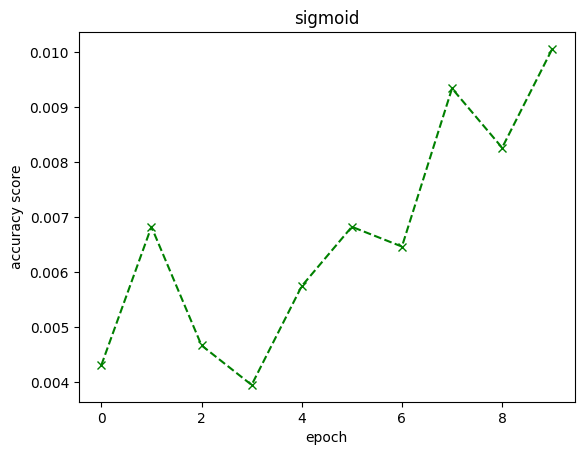

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('sigmoid')
plt.plot(acc,marker='x',color='green',linestyle='dashed')
plt.show()

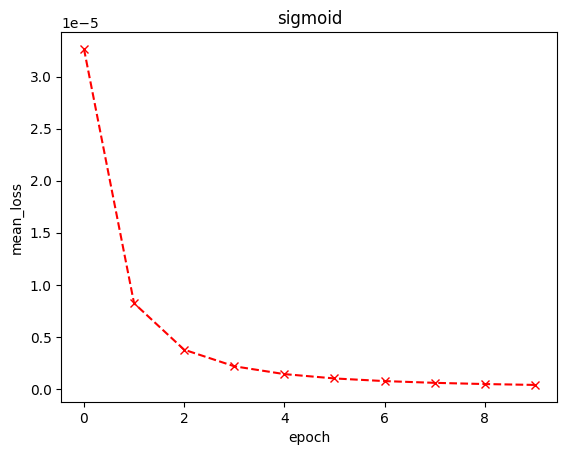

In [14]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('sigmoid')
plt.plot(mean_losses,marker='x',color='red',linestyle='dashed')
plt.show()

In [20]:
def make_prediction(x_test,w1, w2,activation_func):
  y_pred=[]
  for i in range(len(x_test)) :
    out=forward_pass(x_test.values[i],w1, w2,activation_func)
    y_pred.append(np.argmax(out))
  return y_pred

y_pred=make_prediction(X_val,ww1, ww2,"sigmoid")

print("test accuracy is : ",accuracy_score(y_val,y_pred))

test accuracy is :  0.007183908045977011


using TanH activation function

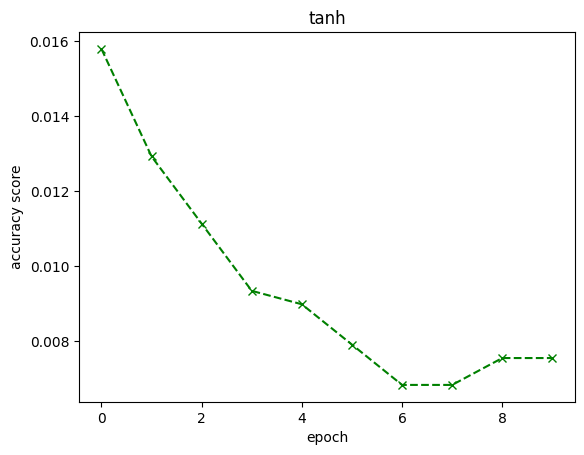

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('tanh')
plt.plot(acc,marker='x',color='green',linestyle='dashed')
plt.show()

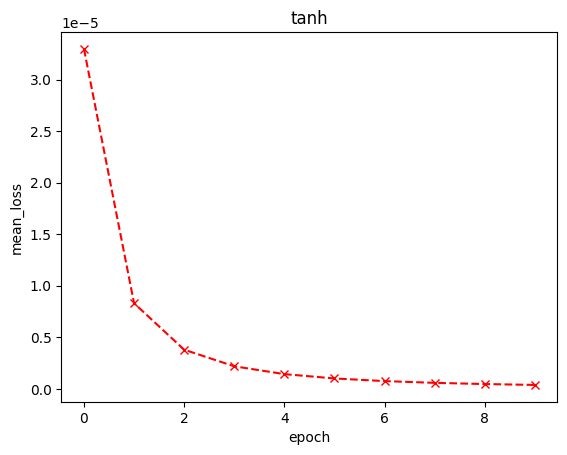

In [29]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('tanh')
plt.plot(mean_losses,marker='x',color='red',linestyle='dashed')
plt.show()

D. Experiment with different weight initialization: Random, Zero & Constant. Create plots to support your arguments. ~[5]

using sigmoid function

In [33]:
acc,mean_losses,ww1,ww2 = train(X_train,y_train,0.1,10,128,"sigmoid","uniform")

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 10%|█         | 1/10 [00:01<00:16,  1.81s/it]

epochs: 1  ========= acc: 0.0025134649910233393  |  loss:  3.289590130728912e-05


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 20%|██        | 2/10 [00:02<00:10,  1.31s/it]

epochs: 2  ========= acc: 0.0025134649910233393  |  loss:  8.255407191673657e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 30%|███       | 3/10 [00:03<00:08,  1.16s/it]

epochs: 3  ========= acc: 0.0017953321364452424  |  loss:  3.7710645743059058e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 40%|████      | 4/10 [00:04<00:06,  1.08s/it]

epochs: 4  ========= acc: 0.002872531418312388  |  loss:  2.1729918771804255e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 50%|█████     | 5/10 [00:06<00:06,  1.22s/it]

epochs: 5  ========= acc: 0.0017953321364452424  |  loss:  1.418861634409295e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 60%|██████    | 6/10 [00:07<00:05,  1.36s/it]

epochs: 6  ========= acc: 0.0021543985637342907  |  loss:  1.0020065798316768e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 70%|███████   | 7/10 [00:08<00:03,  1.27s/it]

epochs: 7  ========= acc: 0.003590664272890485  |  loss:  7.467745553384851e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 80%|████████  | 8/10 [00:09<00:02,  1.18s/it]

epochs: 8  ========= acc: 0.0039497307001795335  |  loss:  5.788700525465391e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 90%|█████████ | 9/10 [00:10<00:01,  1.11s/it]

epochs: 9  ========= acc: 0.00466786355475763  |  loss:  4.62371305618901e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

epochs: 10  ========= acc: 0.003590664272890485  |  loss:  3.781459135723662e-07


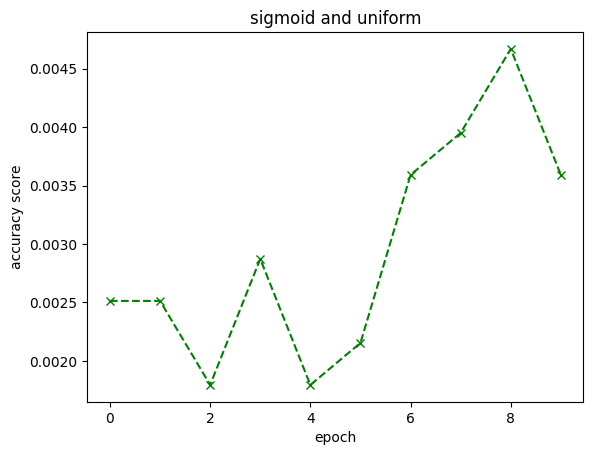

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('sigmoid and uniform')
plt.plot(acc,marker='x',color='green',linestyle='dashed')
plt.show()

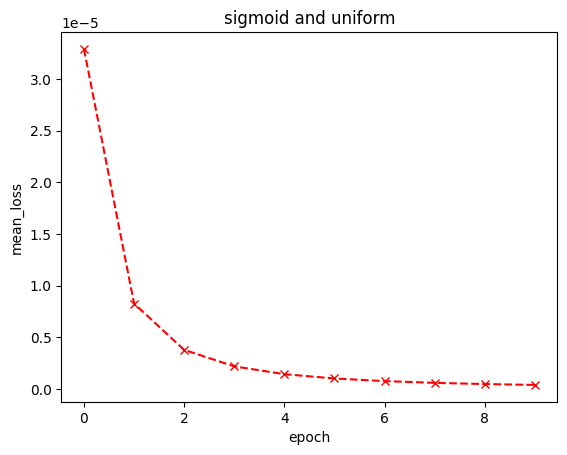

In [35]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('sigmoid and uniform')
plt.plot(mean_losses,marker='x',color='red',linestyle='dashed')
plt.show()

In [36]:
def make_prediction(x_test,w1, w2,activation_func):
  y_pred=[]
  for i in range(len(x_test)) :
    out=forward_pass(x_test.values[i],w1, w2,activation_func)
    y_pred.append(np.argmax(out))
  return y_pred

y_pred=make_prediction(X_val,ww1, ww2,"sigmoid")

print("test accuracy is : ",accuracy_score(y_val,y_pred))

test accuracy is :  0.005028735632183908


using ReLU activation function

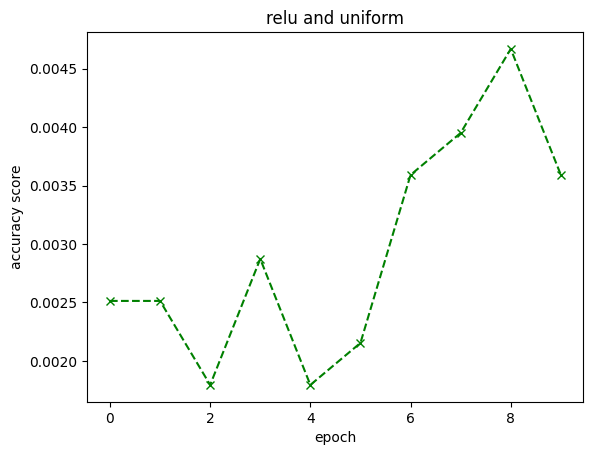

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('relu and uniform')
plt.plot(acc,marker='x',color='green',linestyle='dashed')
plt.show()

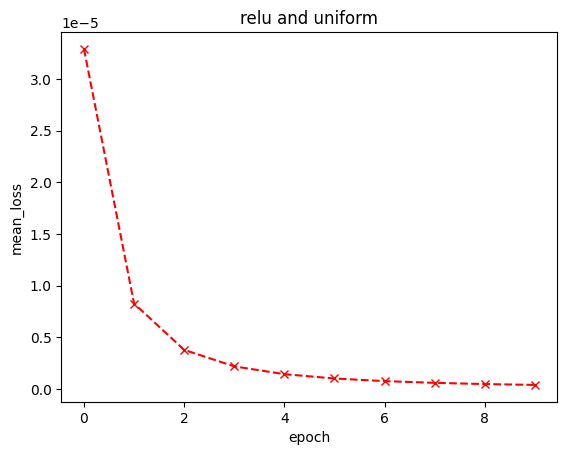

In [39]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('relu and uniform')
plt.plot(mean_losses,marker='x',color='red',linestyle='dashed')
plt.show()

using TanH activation function

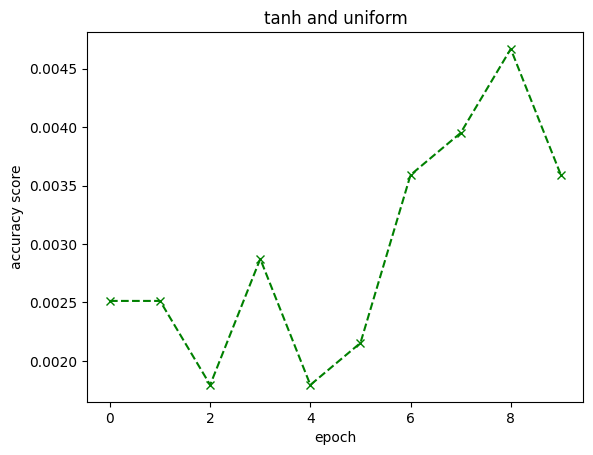

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('tanh and uniform')
plt.plot(acc,marker='x',color='green',linestyle='dashed')
plt.show()

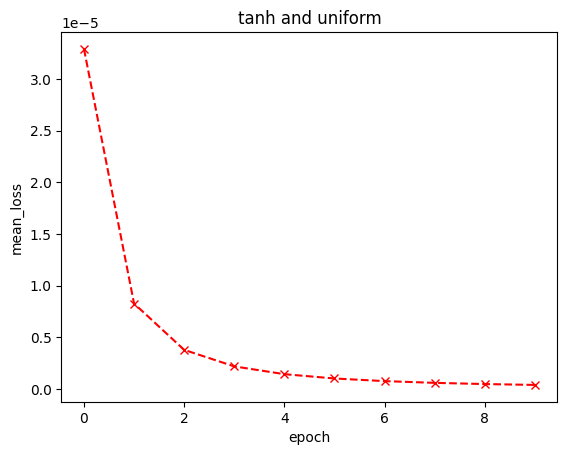

In [43]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('tanh and uniform')
plt.plot(mean_losses,marker='x',color='red',linestyle='dashed')
plt.show()

using 0 intialization of weights

In [44]:
acc,mean_losses,ww1,ww2 = train(X_train,y_train,0.1,10,128,"sigmoid","zero")

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 10%|█         | 1/10 [00:00<00:08,  1.07it/s]

epochs: 1  ========= acc: 0.0  |  loss:  3.2839630294543414e-05


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 20%|██        | 2/10 [00:01<00:07,  1.06it/s]

epochs: 2  ========= acc: 0.0  |  loss:  8.256143493855617e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 30%|███       | 3/10 [00:02<00:06,  1.05it/s]

epochs: 3  ========= acc: 0.0  |  loss:  3.7732282812708927e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 40%|████      | 4/10 [00:03<00:05,  1.04it/s]

epochs: 4  ========= acc: 0.0  |  loss:  2.174737073771792e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 50%|█████     | 5/10 [00:04<00:04,  1.03it/s]

epochs: 5  ========= acc: 0.0  |  loss:  1.420190901745805e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 60%|██████    | 6/10 [00:05<00:03,  1.02it/s]

epochs: 6  ========= acc: 0.0  |  loss:  1.0030322710737163e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 70%|███████   | 7/10 [00:07<00:03,  1.13s/it]

epochs: 7  ========= acc: 0.0  |  loss:  7.475838323389559e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 80%|████████  | 8/10 [00:08<00:02,  1.26s/it]

epochs: 8  ========= acc: 0.0  |  loss:  5.795224659148738e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 90%|█████████ | 9/10 [00:09<00:01,  1.22s/it]

epochs: 9  ========= acc: 0.0  |  loss:  4.629073094885217e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

epochs: 10  ========= acc: 0.0  |  loss:  3.785935091351279e-07


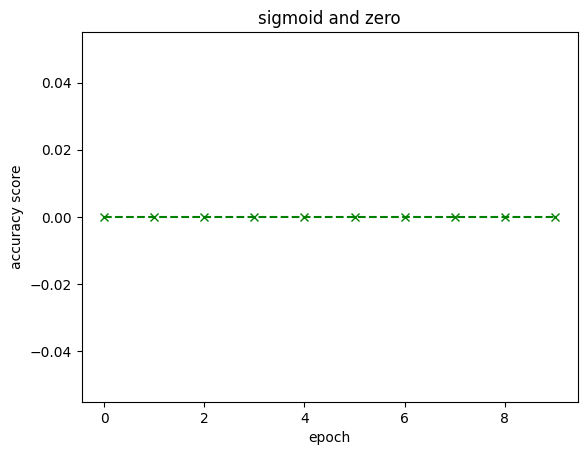

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('sigmoid and zero')
plt.plot(acc,marker='x',color='green',linestyle='dashed')
plt.show()

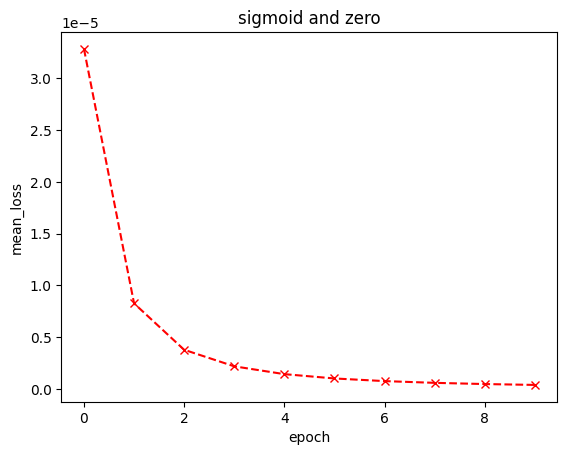

In [46]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('sigmoid and zero')
plt.plot(mean_losses,marker='x',color='red',linestyle='dashed')
plt.show()

using ReLU activation function

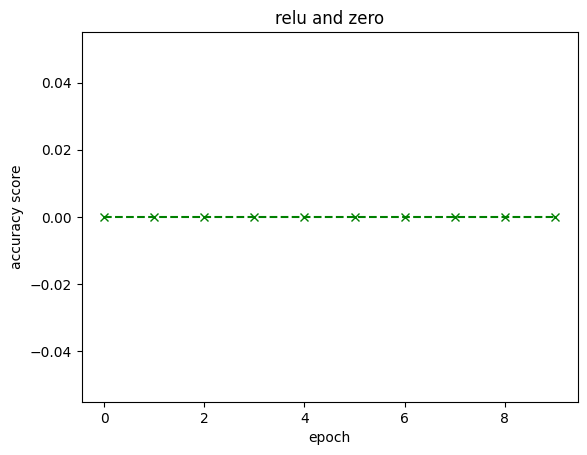

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('relu and zero')
plt.plot(acc,marker='x',color='green',linestyle='dashed')
plt.show()

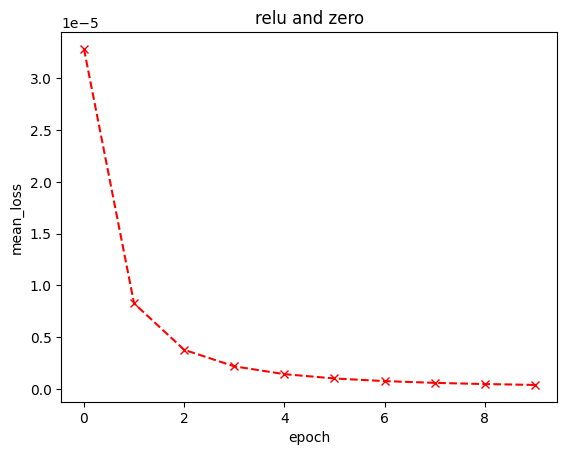

In [50]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('relu and zero')
plt.plot(mean_losses,marker='x',color='red',linestyle='dashed')
plt.show()

using constant weight

In [51]:
acc,mean_losses,ww1,ww2 = train(X_train,y_train,0.1,10,128,"sigmoid","constant")

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 10%|█         | 1/10 [00:02<00:19,  2.15s/it]

epochs: 1  ========= acc: 0.0  |  loss:  3.250716250306445e-05


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 20%|██        | 2/10 [00:05<00:23,  2.94s/it]

epochs: 2  ========= acc: 0.0  |  loss:  8.215959429415552e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 30%|███       | 3/10 [00:06<00:14,  2.10s/it]

epochs: 3  ========= acc: 0.0  |  loss:  3.7604808413349144e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 40%|████      | 4/10 [00:07<00:09,  1.65s/it]

epochs: 4  ========= acc: 0.0  |  loss:  2.16889796325269e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 50%|█████     | 5/10 [00:08<00:06,  1.40s/it]

epochs: 5  ========= acc: 0.0  |  loss:  1.4169406751820066e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 60%|██████    | 6/10 [00:09<00:04,  1.25s/it]

epochs: 6  ========= acc: 0.0  |  loss:  1.000991983676392e-06


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 70%|███████   | 7/10 [00:10<00:03,  1.15s/it]

epochs: 7  ========= acc: 0.0  |  loss:  7.461948935885162e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 80%|████████  | 8/10 [00:11<00:02,  1.08s/it]

epochs: 8  ========= acc: 0.0  |  loss:  5.7852039933929e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
 90%|█████████ | 9/10 [00:12<00:01,  1.04s/it]

epochs: 9  ========= acc: 0.0  |  loss:  4.621522490010461e-07


<ipython-input-5-90b45c87d6f9>:10: RuntimeWarning: overflow encountered in exp
  return 1./(1.+ np.exp(-z))
100%|██████████| 10/10 [00:13<00:00,  1.34s/it]

epochs: 10  ========= acc: 0.0  |  loss:  3.7800511612414814e-07


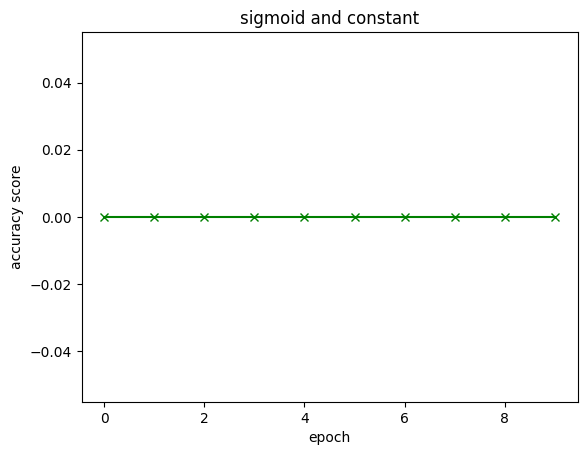

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('sigmoid and constant')
plt.plot(acc,marker='x',color='green')
plt.show()

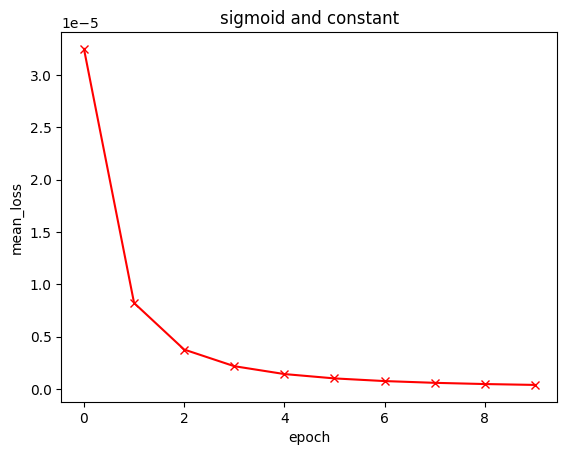

In [53]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('sigmoid and constant')
plt.plot(mean_losses,marker='x',color='red')
plt.show()

using ReLU activation fucntion

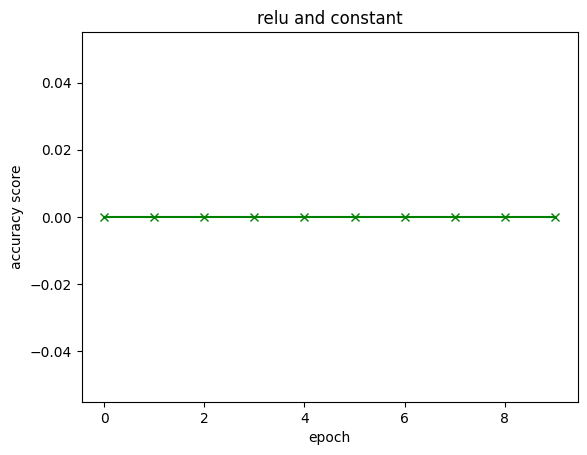

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('relu and constant')
plt.plot(acc,marker='x',color='green')
plt.show()

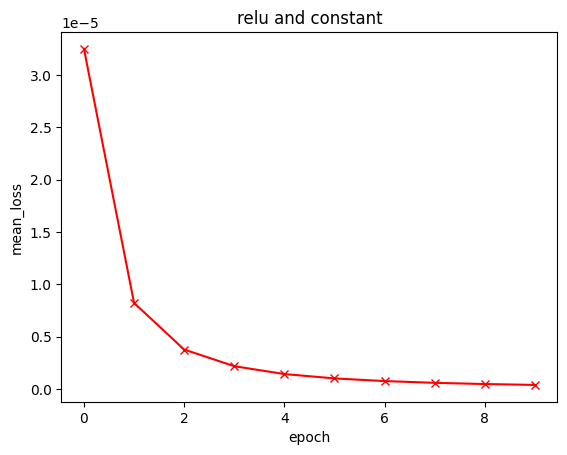

In [55]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('relu and constant')
plt.plot(mean_losses,marker='x',color='red')
plt.show()

using Tanh activation function

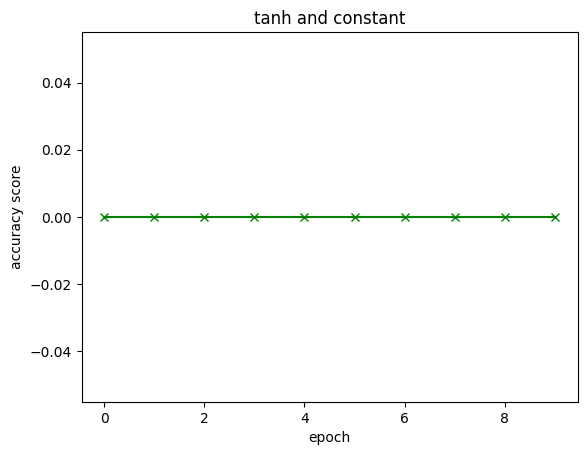

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.title('tanh and constant')
plt.plot(acc,marker='x',color='green')
plt.show()

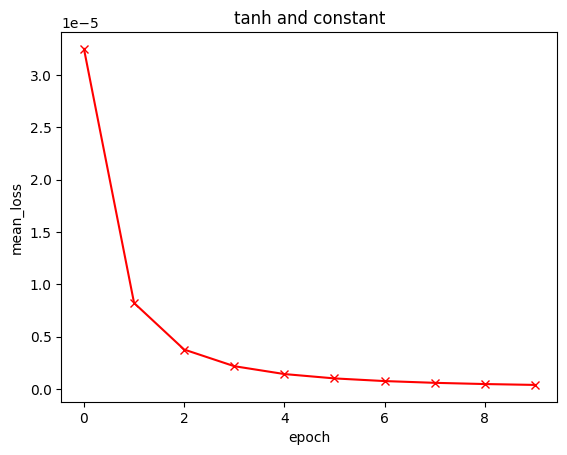

In [57]:
plt.xlabel('epoch')
plt.ylabel('mean_loss')
plt.title('tanh and constant')
plt.plot(mean_losses,marker='x',color='red')
plt.show()

QUESTION 03 will be explained in the report